In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, multivariate_normal
from IPython.display import display, Markdown

# set up the environment
%matplotlib inline
plt.rc("figure", figsize=(16, 6))  # set default size of plots
sns.set_style("whitegrid")  # set default seaborn style
rng = np.random.default_rng()  # random generator

In [2]:
def Black_Scholes_Call(S, K, r, sigma, q, T):
    """Black-Scholes Call option price.

    Args:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free rate
        sigma (float): volatility
        q (float): dividend yield
        T (float): time to maturity

    Returns:
        float: call option price
    """
    if sigma == 0:
        return max(S * np.exp(-q * T) - K * np.exp(-r * T), 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def Black_Scholes_Put(S, K, r, sigma, q, T):
    """Black-Scholes Put option price.

    Args:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free rate
        sigma (float): volatility
        q (float): dividend yield
        T (float): time to maturity

    Returns:
        float: put option price
    """
    if sigma == 0:
        return max(K * np.exp(-r * T) - S * np.exp(-q * T), 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

## Q 8.5 Compare Chooser Option with Straddle Option 

In [3]:
def Chooser(S, Kc, Kp, r, sigma, q, T, Tc, Tp, tol=1e-6):
    # Find the S* such that C(S*, Kc, r, sigma, q, Tc - T) = P(S*, Kp, r, sigma, q, Tp - T)
    if (Tc == Tp) and (Kc == Kp):
        # simple chooser, through put-call parity
        S_star = np.exp((q - r) * (Tc - T)) * Kc
    else:
        # Find the S* by bisection
        def diff(S):
            """Difference between the call and put prices"""
            return Black_Scholes_Call(S, Kc, r, sigma, q, Tc - T) - Black_Scholes_Put(
                S, Kp, r, sigma, q, Tp - T
            )

        lower = 0
        upper = np.exp(q * Tc) * (Kc + Kp)
        assert diff(lower) < 0 & diff(upper) > 0, "Invalid initial bounds for bisection"
        guess = (Kc + Kp) / 2
        while upper - lower > tol:
            if diff(guess) < 0:
                lower = guess
            else:
                upper = guess
            guess = (lower + upper) / 2
        S_star = guess

    # Calculate the option price
    d1 = (np.log(S / S_star) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    d1c = (np.log(S / Kc) + (r - q + sigma**2 / 2) * Tc) / (sigma * np.sqrt(Tc))
    d2c = d1c - sigma * np.sqrt(Tc)
    d1p = (np.log(S / Kp) + (r - q + sigma**2 / 2) * Tp) / (sigma * np.sqrt(Tp))
    d2p = d1p - sigma * np.sqrt(Tp)
    rhoc = np.sqrt(T / Tc)
    rhop = np.sqrt(T / Tp)
    M1c = multivariate_normal.cdf([d1, d1c], cov=[[1, rhoc], [rhoc, 1]])
    M2c = multivariate_normal.cdf([d2, d2c], cov=[[1, rhoc], [rhoc, 1]])
    M1p = multivariate_normal.cdf([-d1, -d1p], cov=[[1, rhop], [rhop, 1]])
    M2p = multivariate_normal.cdf([-d2, -d2p], cov=[[1, rhop], [rhop, 1]])
    return (
        S * np.exp(-q * Tc) * M1c
        - Kc * np.exp(-r * Tc) * M2c
        + Kp * np.exp(-r * Tp) * M2p
        - S * np.exp(-q * Tp) * M1p
    )

In [4]:
# Parameters
S = 50
r = 0.05
sigma = 0.3
q = 0.02
Tc = Tp = 1
T = 0.5
Kc = Kp = S

# Calculate the option price
chooser_price = Chooser(S, Kc, Kp, r, sigma, q, T, Tc, Tp)
straddle_price = Black_Scholes_Call(
    S, Kc, r, sigma, q, Tc) + Black_Scholes_Put(S, Kp, r, sigma, q, Tp)
display(Markdown(f"**Chooser Option Price**: {chooser_price:.4f}"))
display(Markdown(f"**Straddle Option Price**: {straddle_price:.4f}"))

**Chooser Option Price**: 9.9052

**Straddle Option Price**: 11.5718

As in the Section 8.4: "A simple chooser must be cheaper than a straddle with the same exercise price and maturity T ′ = Tc = Tp, because a straddle is always in the money at maturity, whereas a simple chooser has the same value as the straddle if it is in the money but is only in the money at T ′ when the choice made at T turns out to have been the best one."

## Q 8.6 Floating-Strike Lookback Call

**Floating-Strike Lookback Call Pricing Formula** (Eq. 8.30):
$$
e^{-qT}S(0)N(d_1) - e^{-rT}S_{min}N(d_2) \newline
+ \frac{\sigma^2}{2(r-q)}\left(\frac{S_{min}}{S(0)}\right)^{2(r-q)/\sigma^2}e^{-rT}S(0)N(d_2^{\prime}) - \frac{\sigma^2}{2(r-q)}e^{-qT}S(0)N(-d_1)
$$
where
$$
d_1 = \frac{\ln(S(0)/S_{min}) + (r-q+\sigma^2/2)T}{\sigma\sqrt{T}}, \qquad d_2 = d_1 - \sigma\sqrt{T}
$$
$$
d_1^{\prime} = \frac{\ln(S_{min}/S(0)) + (r-q+\sigma^2/2)T}{\sigma\sqrt{T}}, \qquad d_2^{\prime} = d_1^{\prime} - \sigma\sqrt{T}
$$

In [5]:
def Floating_Strike_Lookback_Call(S0, Smin, r, sigma, q, T):
    d1 = (np.log(S0 / Smin) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    d1p = (np.log(Smin / S0) + (r - q + sigma**2 / 2) * T) / \
        (sigma * np.sqrt(T))
    d2p = d1p - sigma * np.sqrt(T)
    x = 2 * (r - q) / sigma**2
    call = (
        S0 * np.exp(-q * T) * norm.cdf(d1)
        - Smin * np.exp(-r * T) * norm.cdf(d2)
        + S0 * np.exp(-r * T) * norm.cdf(d2p) * (Smin / S0) ** x / x
        - S0 * np.exp(-q * T) * norm.cdf(-d1) / x
    )
    return call

In [6]:
# Parameters
S0 = 100  # initial stock price
r = 0.05  # risk-free rate
sigma = 0.3  # volatility
q = 0  # non-dividend paying
T = 2 / 12  # time to maturity (two months)
Smin = S0  # minimum stock price at beginning

# Minimum fee
fee = Floating_Strike_Lookback_Call(S0, Smin, r, sigma, q, T) * np.exp(r * T)  # value at time T
display(Markdown(f"**Minimum Fee**: {fee:.4f}"))

**Minimum Fee**: 9.8684

## Q 8.7 Down-and-Out Call

In [7]:
def Hedged_Cost(S0, K, r, sigma, q, T, L, N, N_con):
    dt = T / N  # time step
    t = np.linspace(0, T, N + 1)  # time grid
    B = np.zeros(N + 1)
    B[1:] = np.cumsum(np.sqrt(dt) * rng.standard_normal(N))  # Brownian motion
    S = S0 * np.exp((r - q - sigma**2 / 2) * t + sigma * B)  # Underlying price
    # whether the option is knocked out
    if any(S < L):
        out = 1
    else:
        out = 0
    # end-of-year costs, net of the option values at maturity
    cost_euro = S[-1] * N_con - np.maximum(S[-1] - K, 0) * N_con
    cost_knockout = S[-1] * N_con - \
        np.maximum(S[-1] - K, 0) * N_con * (1 - out)
    return cost_euro, cost_knockout


def Simulate_Hedge_Cost(S0, K, r, sigma, q, T, L, N, N_con, M):
    costs_euro = np.zeros(M)
    costs_knockout = np.zeros(M)
    for i in range(M):
        costs_euro[i], costs_knockout[i] = Hedged_Cost(
            S0, K, r, sigma, q, T, L, N, N_con
        )
    return costs_euro, costs_knockout

In [8]:
# Parameters
S0 = 50  # initial stock price
K = S0  # strike price (ATM at the beginning)
L = (1 - 0.1) * S0  # barrier (10% below the initial price)
r = 0.05  # risk-free rate
sigma = 0.2  # volatility
q = 0.02  # dividend yield
T = 1  # time to maturity in years
N = 252  # number of periods in a year
N_con = 100  # number of contracts
M = 500  # number of simulations

# Simulation
costs_euro, costs_knockout = Simulate_Hedge_Cost(
    S0, K, r, sigma, q, T, L, N, N_con, M)

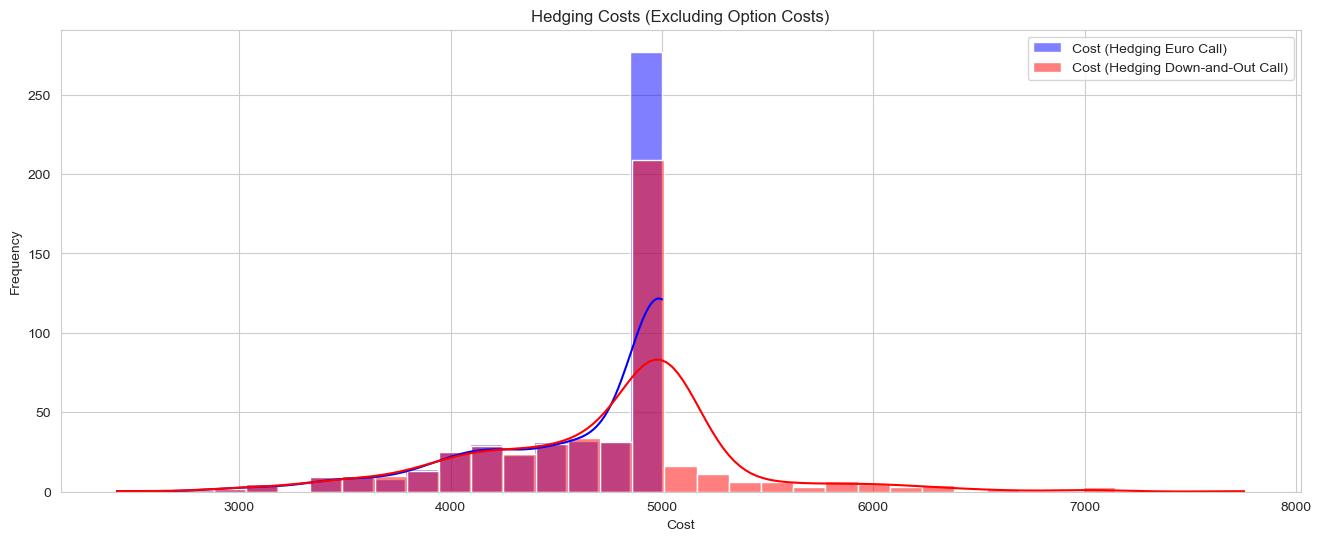

In [9]:
# Histogram
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(costs_euro, kde=True, color="blue", label="Cost (Hedging Euro Call)")
sns.histplot(
    costs_knockout, kde=True, color="red", label="Cost (Hedging Down-and-Out Call)"
)
plt.xlabel("Cost")
plt.ylabel("Frequency")
plt.title("Hedging Costs (Excluding Option Costs)")
plt.legend()
plt.show()

As shown in the histogram above, the costs using a European call hedging are truncated at $K$ multiplying the number of contracts, while the costs using down-and-out call hedging might exceed this level.

### Followup: Q 8.8 end-of-year costs including the costs of the options

In [10]:
def Down_And_Out_Call(S, K, r, sigma, q, T, L):
    if K > L:
        d1 = (np.log(S / K) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d1p = (np.log(L**2 / (K * S)) + (r - q + sigma**2 / 2) * T) / (
            sigma * np.sqrt(T)
        )
    else:
        d1 = (np.log(S / L) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d1p = (np.log(L / S) + (r - q + sigma**2 / 2) * T) / \
            (sigma * np.sqrt(T))

    d2 = d1 - sigma * np.sqrt(T)
    d2p = d1p - sigma * np.sqrt(T)
    price = np.exp(-q * T) * S * (
        norm.cdf(d1)
        - (L / S) ** (2 * (r - q + sigma**2 / 2) / sigma**2) * norm.cdf(d1p)
    ) - np.exp(-r * T) * K * (
        norm.cdf(d2)
        - (L / S) ** (2 * (r - q - sigma**2 / 2) / sigma**2) * norm.cdf(d2p)
    )
    return price

In [11]:
C0_euro = Black_Scholes_Call(S0, K, r, sigma, q, T)
display(Markdown(f"**Black-Scholes Call Option Price**: {C0_euro:.4f}"))

C0_knockout = Down_And_Out_Call(S0, K, r, sigma, q, T, L)
display(Markdown(f"**Down-and-Out Call Option Price**: {C0_knockout:.4f}"))

**Black-Scholes Call Option Price**: 4.6135

**Down-and-Out Call Option Price**: 3.7935

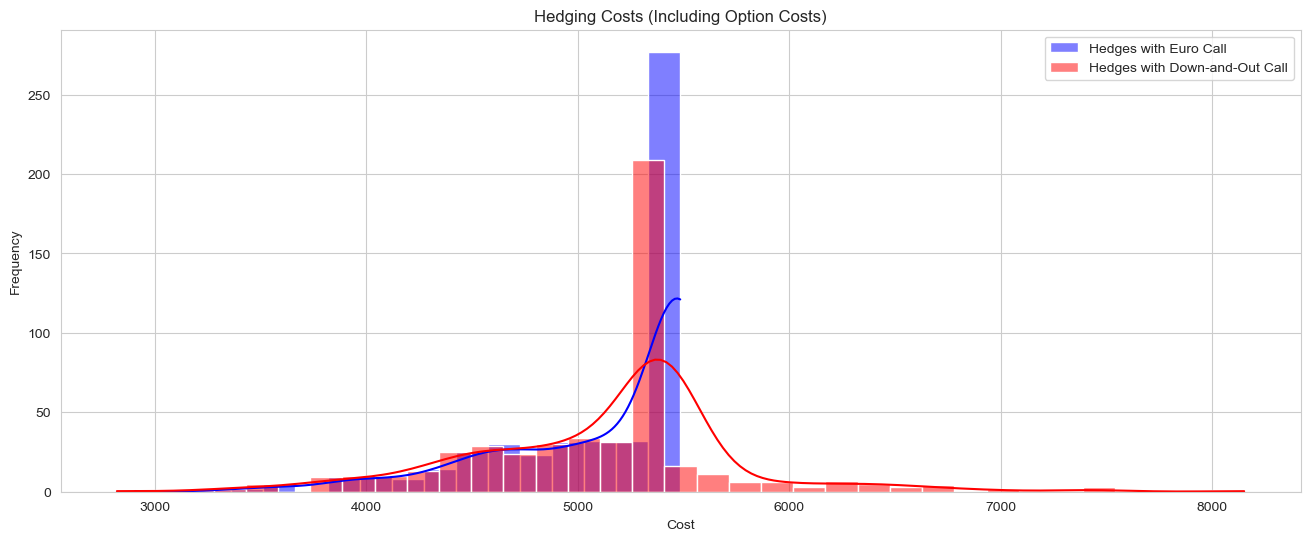

In [12]:
# Modified costs
costs_euro = costs_euro + C0_euro * np.exp(r * T) * N_con
costs_knockout = costs_knockout + C0_knockout * np.exp(r * T) * N_con

# Histogram
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(costs_euro, kde=True, color="blue", label="Hedges with Euro Call")
sns.histplot(costs_knockout, kde=True, color="red",
             label="Hedges with Down-and-Out Call")
plt.xlabel("Cost")
plt.ylabel("Frequency")
plt.title("Hedging Costs (Including Option Costs)")
plt.legend()
plt.show()

Similarly, the costs using a European call hedging are truncated at $K$ multiplying the number of contracts, plus the costs of the options. The costs using down-and-out call hedging might exceed this level, but have a lower costs for the options.